# Решающие деревья и решающие леса.

# 1. Решающие деревья

## Задание 1. Решающие деревья на искусственно сгенерированных данных.

Рассмотрим модельную задачу регрессии. Объектами будут являться точки на плоскости (т.е. каждый объект описывается 2 признаками), целевая переменная — расстояние от объекта до точки (0, 0).

In [21]:
%pylab inline
import numpy as np
import pandas as pd
import pylab as plt

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

Populating the interactive namespace from numpy and matplotlib


C:\Users\elena\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['indices', 'clf', 'plt', 'mean', 'std']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Напишем вспомогательную функцию, которая будет возвращать решетку для дальнейшей красивой визуализации

In [2]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

Сгенерируем выборку

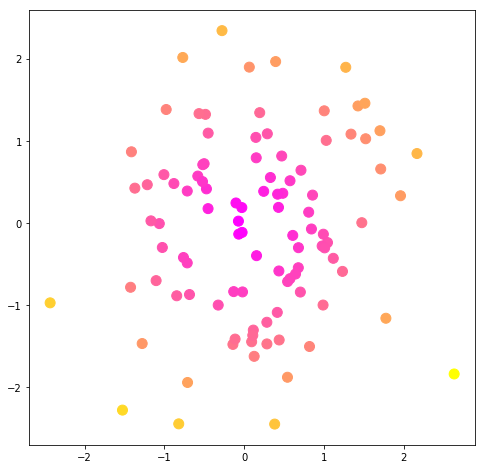

In [3]:
data_x = np.random.normal(size=(100, 2))
data_y = (data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5
plt.figure(figsize=(8, 8))
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring')

In [4]:
from sklearn.tree import DecisionTreeRegressor

Обучим дерево на сгенерированных данных и предскажем ответы для каждой точки решетки

[[-3.43230824 -3.44793338]
 [-3.42230824 -3.44793338]
 [-3.41230824 -3.44793338]
 ...
 [ 3.60769176  3.33206662]
 [ 3.61769176  3.33206662]
 [ 3.62769176  3.33206662]]


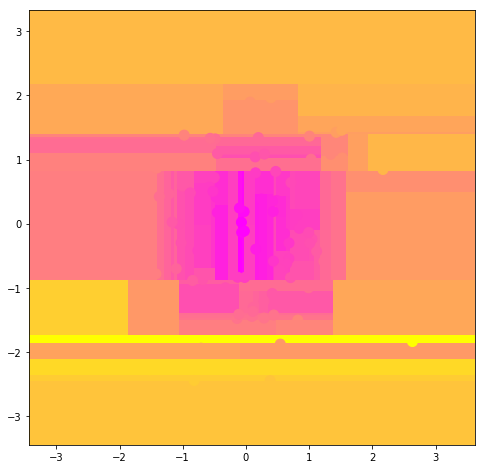

In [5]:
clf = DecisionTreeRegressor()
clf.fit(data_x, data_y)

xx, yy = get_grid(data_x)
print(np.c_[xx.ravel(), yy.ravel()])

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap='spring')
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring')

Посмотрим как будет выглядеть разделяющая поверхность в зависимости от 
- минимального количества объектов в листе
- максимальной глубины дерева

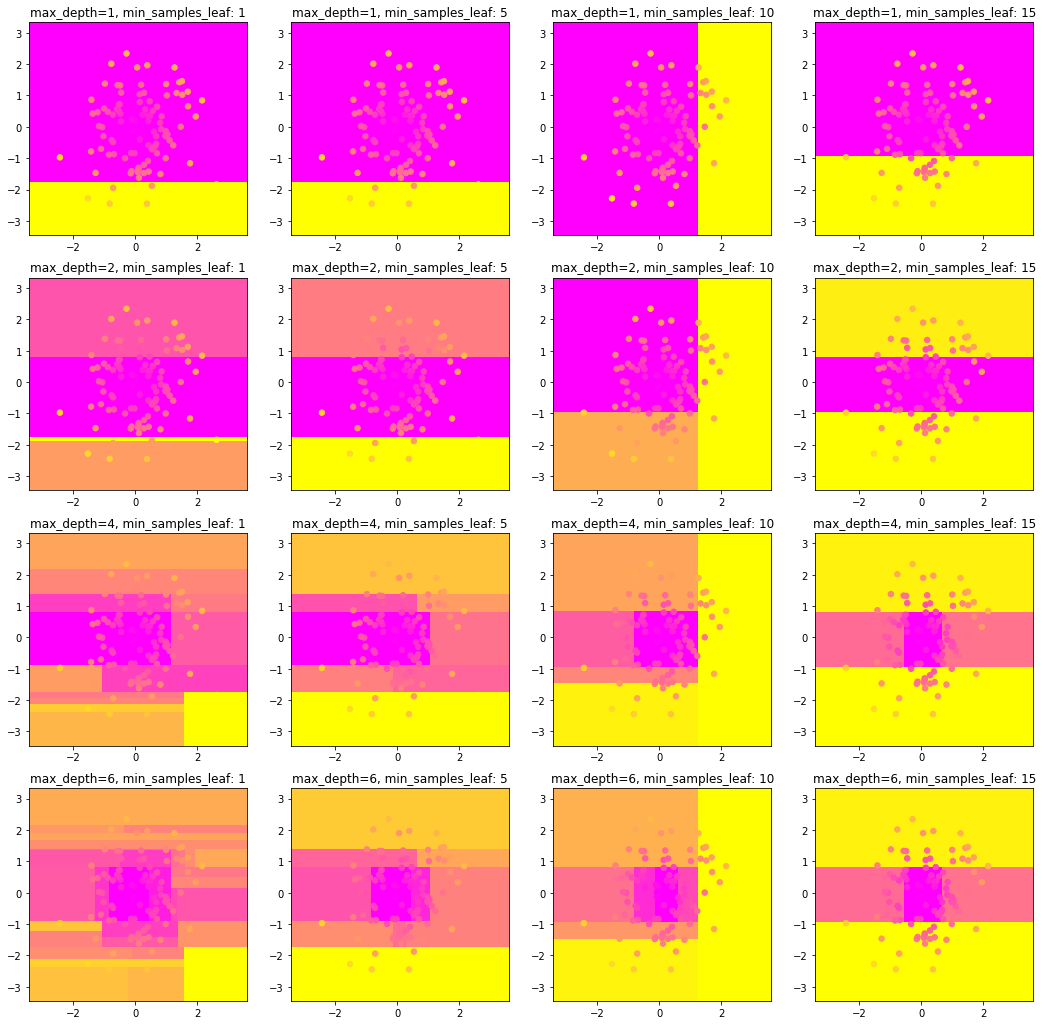

In [6]:
plt.figure(figsize=(18, 18))
for i, max_depth in enumerate([1, 2, 4, 6]):
    for j, min_samples_leaf in enumerate([1, 5, 10, 15]):
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(data_x, data_y)
        xx, yy = get_grid(data_x)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
        plt.subplot2grid((4, 4), (i, j))
        plt.pcolormesh(xx, yy, predicted, cmap='spring')
        plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='spring')
        plt.title('max_depth=' + str(max_depth) + ', min_samples_leaf: ' + str(min_samples_leaf))

- Как влияет увеличение максимальной глубины и/или уменьшение минимального количества объектов выборки в листе на качество на обучающей выборке? на переобучение?

### Неустойчивость решающих деревьев

Решающие деревья — это алгоритмы, неустойчивые к изменениям обучающей выборки, т.е. при малейших её изменениях итоговый классификатор может радикально измениться.
Посмотрим, как будет меняться структура дерева при обучении на разных 90%-х подвыборках.


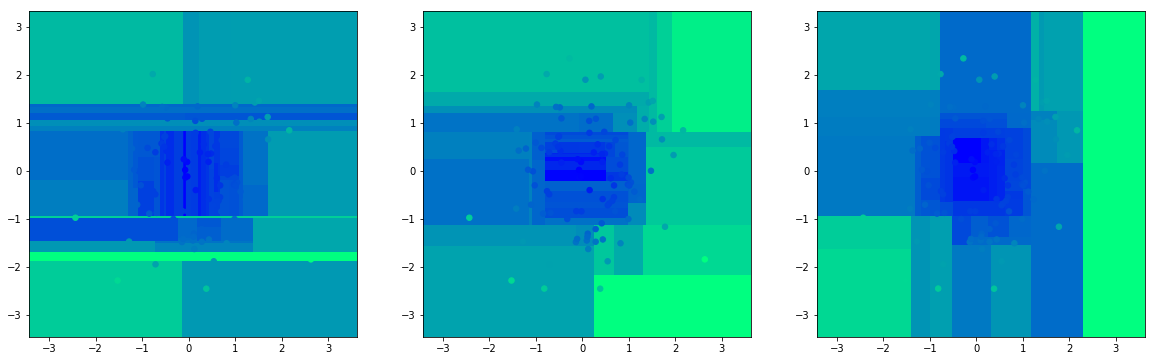

In [7]:
plt.figure(figsize=(20, 6))
for i in range(3):
    clf = DecisionTreeRegressor(random_state=42)

    indices = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.9))
    clf.fit(data_x[indices], data_y[indices])
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='winter')
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='winter')

## Задание 2. Подбор параметров для решающего дерева в задаче Boston Houses.

Посмотрим на качество дерева в зависимости от параметров на одном из стандартных наборов данных - Бостонском датасете.

In [28]:
from sklearn.datasets import load_boston

In [29]:
data = load_boston()
print(data.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [30]:
X_full = data.data
y_full = data.target

print(X_full[:3])

[[6.3200e-03 1.8000e+01 2.3100e+00 0.0000e+00 5.3800e-01 6.5750e+00
  6.5200e+01 4.0900e+00 1.0000e+00 2.9600e+02 1.5300e+01 3.9690e+02
  4.9800e+00]
 [2.7310e-02 0.0000e+00 7.0700e+00 0.0000e+00 4.6900e-01 6.4210e+00
  7.8900e+01 4.9671e+00 2.0000e+00 2.4200e+02 1.7800e+01 3.9690e+02
  9.1400e+00]
 [2.7290e-02 0.0000e+00 7.0700e+00 0.0000e+00 4.6900e-01 7.1850e+00
  6.1100e+01 4.9671e+00 2.0000e+00 2.4200e+02 1.7800e+01 3.9283e+02
  4.0300e+00]]


In [31]:
X_full.shape

(506, 13)

In [32]:
y_full[:10]

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9])

- разобъём все данные на train и test
- будем оценивать качество алгоритма по кросс-валидации

In [33]:
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(X_full, y_full, test_size=100, 
                                        random_state=241)

In [34]:
from sklearn.model_selection import KFold, cross_val_score
cv = KFold(X.shape[0], shuffle=True, random_state=241)

In [35]:
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(random_state=241)
print(-cross_val_score(regr, X, y, cv=cv, 
                       scoring='neg_mean_squared_error').mean())

26.10864532019704


In [36]:
regr.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=241, splitter='best')

Метрика MSЕ имеет не ограничена сверху. Поэтому для оценки качества алгоритма можно также пользоваться метрикой R2 (коэффициент детерминации), так как он не превышает 1 (и чем ближе к 1, тем лучше).

Выведем на экран значение R2 алгоритма ('r2').

In [37]:
print(cross_val_score(regr, X, y, cv=cv, 
                       scoring='r2_score').mean())

Для сравнения качества модели при различных наборах параметров или для сравнения моделей на одном датасете можно использовать, как и раньше, MSE.

Будем подбирать параметры решающего дерева по сетке с целью увеличить качество алгоритма. Будем подбирать значения max_features и max_depth.

In [38]:
from sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [39]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(DecisionTreeRegressor(random_state=241),
                  param_grid={'max_features': [None, 'log2', 'sqrt'], 
                              'max_depth': [2, 4, 6, 8, 10, 20, 50]},
                  cv=cv,
                  scoring='neg_mean_squared_error')
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=406, random_state=241, shuffle=True),
       error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=241, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': [None, 'log2', 'sqrt'], 'max_depth': [2, 4, 6, 8, 10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [40]:
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))

-27.455 (+/-153.418) for {'max_depth': 2, 'max_features': None}
-49.473 (+/-289.871) for {'max_depth': 2, 'max_features': 'log2'}
-49.473 (+/-289.871) for {'max_depth': 2, 'max_features': 'sqrt'}
-20.683 (+/-155.971) for {'max_depth': 4, 'max_features': None}
-48.721 (+/-270.245) for {'max_depth': 4, 'max_features': 'log2'}
-48.721 (+/-270.245) for {'max_depth': 4, 'max_features': 'sqrt'}
-22.043 (+/-162.066) for {'max_depth': 6, 'max_features': None}
-31.778 (+/-210.762) for {'max_depth': 6, 'max_features': 'log2'}
-31.778 (+/-210.762) for {'max_depth': 6, 'max_features': 'sqrt'}
-22.736 (+/-161.233) for {'max_depth': 8, 'max_features': None}
-22.683 (+/-140.568) for {'max_depth': 8, 'max_features': 'log2'}
-22.683 (+/-140.568) for {'max_depth': 8, 'max_features': 'sqrt'}
-21.826 (+/-153.578) for {'max_depth': 10, 'max_features': None}
-28.645 (+/-159.855) for {'max_depth': 10, 'max_features': 'log2'}
-28.645 (+/-159.855) for {'max_depth': 10, 'max_features': 'sqrt'}
-26.109 (+/-177.7

# Задание

Теперь попробуем одновременно подбирать значения max_features, max_depth и min_samples_leaf. Ищите min_samples_leaf в диапазоне range(1,20).

In [45]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(DecisionTreeRegressor(random_state=241),
                  param_grid={'max_features': [None, 'log2', 'sqrt'], 
                              'max_depth': [2, 4, 6, 8, 10, 20, 50],
                              'min_samples_leaf': np.arange(1,20,1)},
                  cv=cv,
                  scoring='neg_mean_squared_error')
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=406, random_state=241, shuffle=True),
       error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=241, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': [None, 'log2', 'sqrt'], 'max_depth': [2, 4, 6, 8, 10, 20, 50], 'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [52]:
gs.best_score_, gs.best_params_

(-18.933183827134346,
 {'max_depth': 8, 'max_features': None, 'min_samples_leaf': 9})

Как в данной задаче зависит качество алгоритма от количества параметров, которые мы оптимизируем?

# 2. Решающий лес

Посмотрим, какое качество в задаче Boston Houses можно получить при использовании решающего леса.

In [57]:
regr = DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 9)
t1 = time.time()
print(-cross_val_score(regr, X, y, cv=cv,
                       scoring='neg_mean_squared_error').mean())
t2 = time.time()
print('time:', t2-t1)

18.933183827134354
time: 1.5622663497924805


Выведите среднюю квадратичную ошибку на кросс-валидации для решающего леса с количеством деревьев n_estimators: 10, 100, 1000.

In [58]:
from sklearn.ensemble import RandomForestRegressor
import time

regr = RandomForestRegressor(n_estimators=10)

t1 = time.time()
print(-cross_val_score(regr, X, y, cv=cv,
                       scoring='neg_mean_squared_error').mean())
t2 = time.time()
print('time:', t2-t1)

12.270934236453206
time: 15.9716215133667


In [34]:
regr = RandomForestRegressor(n_estimators=100)

t1 = time.time()
print(-cross_val_score(regr, X, y, cv=cv,
                       scoring='neg_mean_squared_error').mean())
t2 = time.time()
print('time:', t2-t1)

11.467040955665016
time: 68.83440518379211


In [59]:
regr = RandomForestRegressor(n_estimators=1000)

t1 = time.time()
print(-cross_val_score(regr, X, y, cv=cv,
                       scoring='neg_mean_squared_error').mean())
t2 = time.time()
print('time:', t2-t1)

11.231565154088663
time: 1683.4926135540009


Построим график качества классификации на кросс-валидации в зависимости от числа деревьев.

На каждой итерации цикла обучаем регрессор командой regr = ... и добавляем в список Scores число cross_val_score:
Scores.append(cross_val_score(...))

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [10:36<00:00, 127.41s/it]


([<matplotlib.axis.XTick at 0x182123947f0>,
 <a list of 6 Text xticklabel objects>)

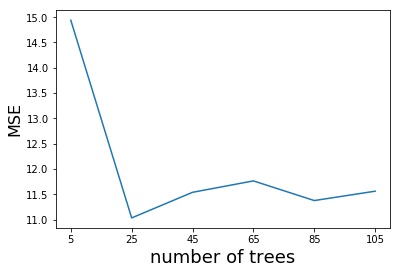

In [60]:
from tqdm import tqdm

Ntrees = np.arange(5,120,20)
Scores = []

for elem in tqdm(Ntrees):
    regr = RandomForestRegressor(n_estimators=elem)
    Scores.append(-cross_val_score(regr, X, y, cv=cv,
                       scoring='neg_mean_squared_error').mean())
    
plot(Scores)
xlabel('number of trees', fontsize=18)
ylabel('MSE', fontsize=16)
xticks(arange(len(Ntrees)), Ntrees)

Построим график количества времени, потраченного на обучение в зависимости от числа деревьев.

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [10:37<00:00, 127.74s/it]


([<matplotlib.axis.XTick at 0x1821235d7b8>,
 <a list of 6 Text xticklabel objects>)

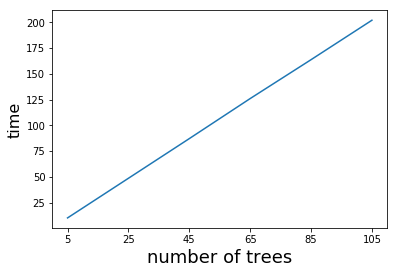

In [61]:
from tqdm import tqdm

Ntrees = np.arange(5,120,20)
Times = []

for elem in tqdm(Ntrees):
    regr = RandomForestRegressor(n_estimators=elem)
    t1 = time.time()
    s = -cross_val_score(regr, X, y, cv=cv,
                       scoring='neg_mean_squared_error').mean()
    t2 = time.time()
    Times.append(t2-t1)
    
plot(Times)
xlabel('number of trees', fontsize=18)
ylabel('time', fontsize=16)
xticks(arange(len(Ntrees)), Ntrees)